# IBM Data Science Capstone Project
This notebook is used for the IBM Data Science Specialisation Capstone Project.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from pandas.tools.plotting import scatter_matrix
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


## 1. Data Preprocessing

### 1.1 Load Data

In [3]:
acc=pd.read_csv('Accident_Information.csv',encoding='latin')
veh=pd.read_csv('Vehicle_Information.csv',encoding='latin')
#Merging the datasets
df=pd.merge(veh,acc,how='inner',on='Accident_Index')
print(df.shape)
df.head()

(2058408, 57)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_y,InScotland
0,200501BS00002,36 - 45,3.0,Data missing or out of range,NaN,8268.0,None,None,Journey as part of work,Leaving roundabout,...,Metropolitan Police,Dry,Dual carriageway,None,30.0,17:36,Urban,Fine no high winds,2005,No
1,200501BS00003,26 - 35,5.0,Urban area,3.0,8300.0,Parked vehicle,None,Journey as part of work,Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,None,30.0,00:15,Urban,Fine no high winds,2005,No
2,200501BS00004,46 - 55,4.0,Urban area,1.0,1769.0,None,None,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,None,30.0,10:35,Urban,Fine no high winds,2005,No
3,200501BS00005,46 - 55,10.0,Data missing or out of range,NaN,85.0,Kerb,None,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,21:13,Urban,Fine no high winds,2005,No
4,200501BS00006,46 - 55,1.0,Urban area,4.0,2976.0,None,None,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.0,12:40,Urban,Raining no high winds,2005,No


### 1.2 Sample data

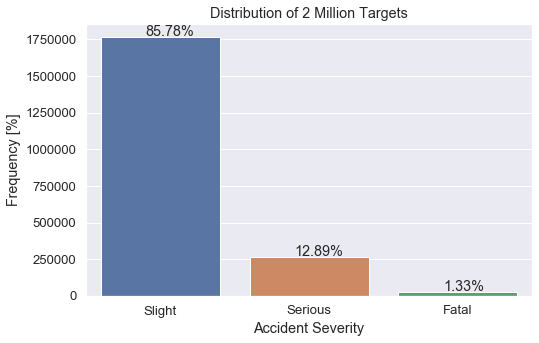

In [4]:
sns.set(font_scale=1.2)
plt.figure(figsize=(8,5))
ax=sns.countplot(x=df.Accident_Severity)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.title('Distribution of 2 Million Targets')
plt.show()

In [5]:
# Creating weights that are opposite to the weights of target
weights = np.where(df['Accident_Severity'] == 'Slight', .2, .8)
weights

array([0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2])

In [6]:
#Sampling only 30% of the data with new weights  
df = df.sample(frac=0.3,replace=True,weights=weights)
print(df.shape)

(617522, 57)


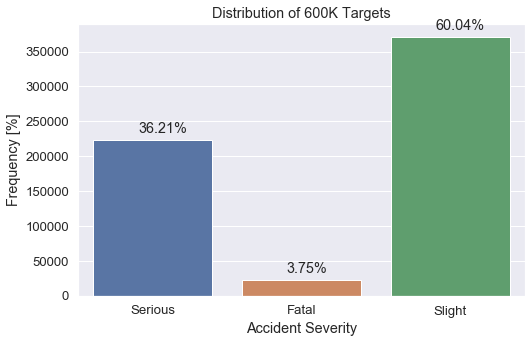

In [7]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x=df.Accident_Severity)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.title('Distribution of 600K Targets')
plt.show()

### 1.3 Null values in data

In [8]:
#Null values in the columns
null_count=df.isnull().sum()
null_count[null_count>0]

Age_of_Vehicle                                 102870
Driver_IMD_Decile                              207055
Engine_Capacity_.CC.                            76015
make                                            34408
model                                           96452
Propulsion_Code                                 70780
Vehicle_Location.Restricted_Lane                  307
2nd_Road_Class                                 263792
2nd_Road_Number                                  5879
Did_Police_Officer_Attend_Scene_of_Accident        42
Latitude                                           28
Location_Easting_OSGR                              28
Location_Northing_OSGR                             28
Longitude                                          28
LSOA_of_Accident_Location                       44609
Pedestrian_Crossing-Human_Control                 202
Pedestrian_Crossing-Physical_Facilities           364
Speed_limit                                        13
Time                        

### 1.4 Exploratory data analysis

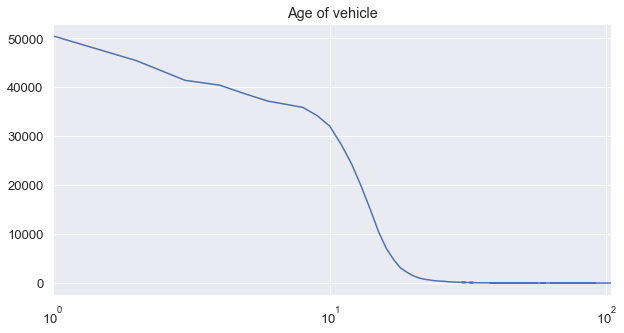

Min: 1.0 
Max: 104.0 
Median: 7.0


In [46]:
df.Age_of_Vehicle.value_counts().plot(figsize=(10,5),logx=True)
plt.title('Age of vehicle')
plt.show()
print('Min:',    df.Age_of_Vehicle.min(), '\n'
      'Max:',    df.Age_of_Vehicle.max(), '\n'
      'Median:', df.Age_of_Vehicle.median())

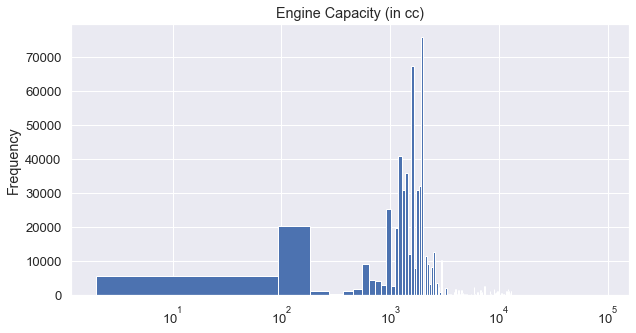

Min: 2.0 
Max: 91000.0 
Median: 1598.0


In [45]:
df['Engine_Capacity_.CC.'].plot('hist',bins=1000,figsize=(10,5),logx=True)
plt.title('Engine Capacity (in cc)')
plt.show()
print('Min:',    df['Engine_Capacity_.CC.'].min(), '\n'
      'Max:',    df['Engine_Capacity_.CC.'].max(), '\n'
      'Median:', df['Engine_Capacity_.CC.'].median())

### 1.5 Feature selection and more exploratory analysis

#### Create new dataframe with 25 features only

In [11]:
df2 = df[['Accident_Index', '1st_Road_Class','Day_of_Week', 'Junction_Detail','Light_Conditions', 'Number_of_Casualties',
          'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit',
          'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Age_of_Vehicle',
          'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'make', 'Engine_Capacity_.CC.', 'Sex_of_Driver',
          'Skidding_and_Overturning', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Accident_Severity'
         ]]
df2.shape

(617522, 25)

In [48]:
df2.head()

,Accident_Index,1st_Road_Class,Day_of_Week,Junction_Detail,Light_Conditions,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,...,Age_of_Vehicle,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,make,Engine_Capacity_.CC.,Sex_of_Driver,Skidding_and_Overturning,Vehicle_Manoeuvre,Vehicle_Type,Accident_Severity_Slight
892589,2011120033766,A,Wednesday,Not at junction or within 20 metres,Daylight,1,2,Wet or damp,Single carriageway,None,...,7.0,None,None,SCANIA,15607.0,Male,None,Reversing,Goods 7.5 tonnes mgw and over,0
1118119,2012350212112,A,Saturday,Not at junction or within 20 metres,Daylight,5,3,Dry,Single carriageway,None,...,4.0,None,None,PERODUA,1298.0,Male,None,Going ahead right-hand bend,Car,0
784164,2010070171227,C,Wednesday,Not at junction or within 20 metres,Daylight,1,2,Dry,Single carriageway,None,...,20.0,None,None,BMW,750.0,Male,None,Going ahead other,Motorcycle over 500cc,1
1822070,201601BS70346,A,Monday,Crossroads,Daylight,1,2,Dry,Single carriageway,None,...,NaN,None,None,MERCEDES,1461.0,Male,None,Going ahead other,Car,0
286989,2007230795809,A,Monday,Private drive or entrance,Daylight,5,3,Dry,Single carriageway,None,...,8.0,None,None,HONDA,1997.0,Male,None,Going ahead other,Car,1


#### Correlation Matrix

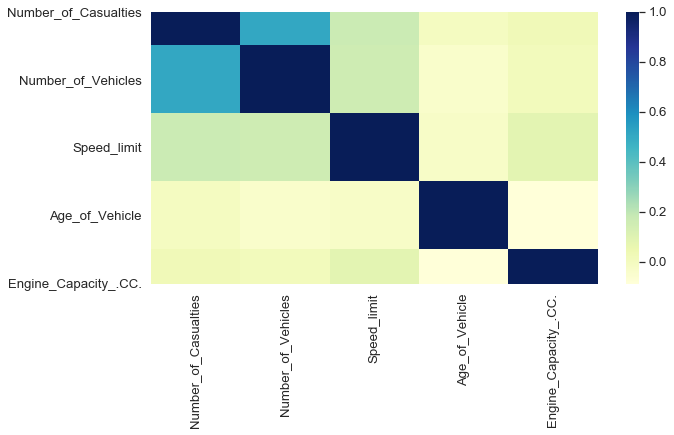

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(df2.corr(),cmap='YlGnBu')
plt.show()

#### Distribution of "Number of Vehicles"

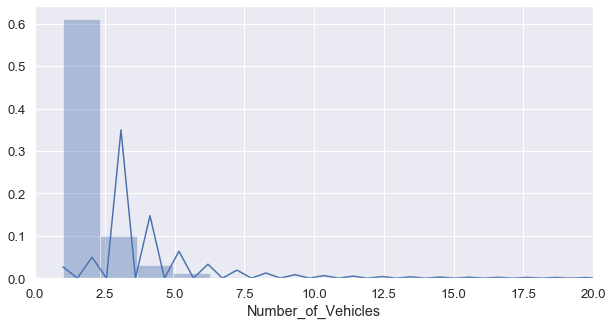

Min: 1 
Max: 67 
Median: 2.0


In [13]:
plt.figure(figsize=(10,5))
sns.distplot(df2['Number_of_Vehicles'])
plt.xlim(0,20)
plt.show()
print('Min:',    df2.Number_of_Vehicles.min(), '\n'
      'Max:',    df2.Number_of_Vehicles.max(), '\n'
      'Median:', df2.Number_of_Vehicles.median())

#### Distribution of "Number of Casualities"

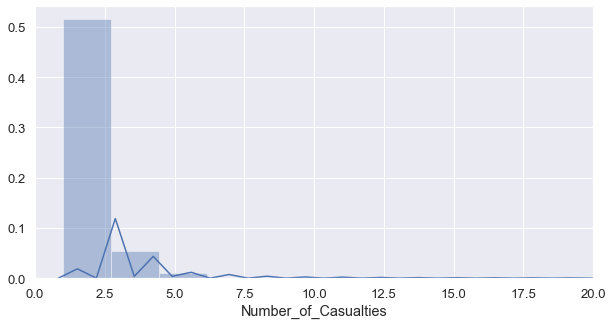

Min: 1 
Max: 87 
Median: 1.0


In [42]:
plt.figure(figsize=(10,5))
sns.distplot(df2.Number_of_Casualties).set_xlim(0,20)
plt.show()
print('Min:',    df2.Number_of_Casualties.min(), '\n'
      'Max:',    df2.Number_of_Casualties.max(), '\n'
      'Median:', df2.Number_of_Casualties.median())

#### Distribution of accidents over the day

Text(0.5, 1.0, 'Accidents over the day')

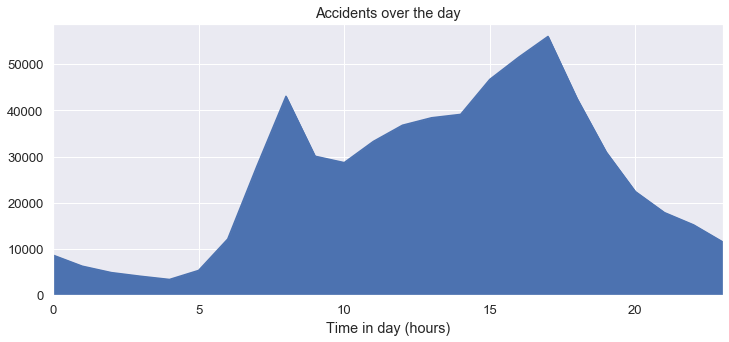

In [44]:
time_x = pd.to_datetime(df2['Time'], format='%H:%M').dt.hour
plt.figure(figsize=(12,5))
time_x.value_counts().sort_index().plot('area')
plt.xlabel("Time in day (hours)")
plt.title("Accidents over the day")

#### Multi-class to Two-class

In [16]:
df2['Accident_Severity'] = df2['Accident_Severity'].replace(['Serious', 'Fatal'], 'Serious or Fatal')
df2 = pd.get_dummies(df2, columns=['Accident_Severity'])
df2 = df2.drop('Accident_Severity_Serious or Fatal', axis=1)
df2.Accident_Severity_Slight.value_counts(normalize=True)

1    0.600362
0    0.399638
Name: Accident_Severity_Slight, dtype: float64

In [17]:
acc_slight = df2.Accident_Severity_Slight == 1
acc_severe = df2.Accident_Severity_Slight == 0
acc_slight.shape

(617522,)

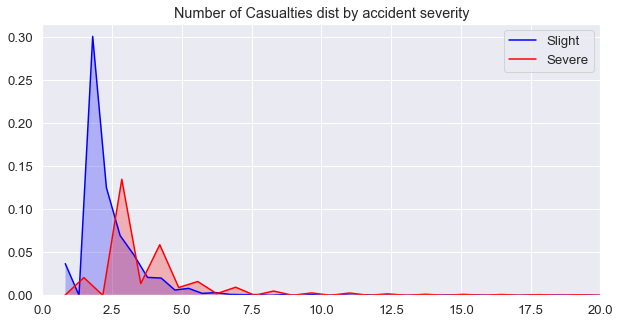

In [18]:
plt.figure(figsize=(10,5))
sns.kdeplot(df2.Number_of_Casualties[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Casualties[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)
plt.title('Number of Casualties dist by accident severity')
plt.show()

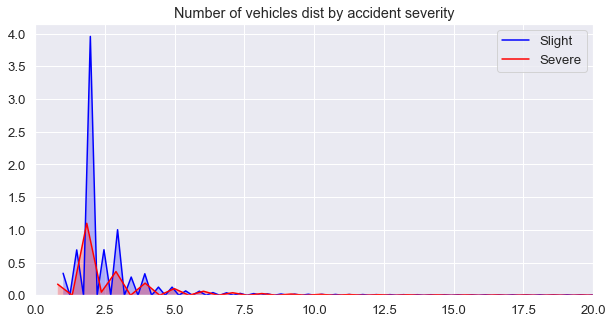

In [19]:
plt.figure(figsize=(10,5))
sns.kdeplot(df2.Number_of_Vehicles[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Vehicles[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)
plt.title('Number of vehicles dist by accident severity')
plt.show()

## 2. Feature Engineering and Pipelines

### 2.1 Split data into feature and target sets

In [20]:
X = df2.drop(['Accident_Index','Accident_Severity_Slight'], axis=1)
y = df2.Accident_Severity_Slight
print(X.shape,
      y.shape)

(617522, 23) (617522,)


### 2.2 Pipelines for individual features

### Transform Speed Limit

In [21]:
def get_Speed_limit(df):
    return df[['Speed_limit']]

FullTransformerOnSpeedLimit = Pipeline([("Select_Speed_Limit", FunctionTransformer(func=get_Speed_limit, validate=False)),
                                        ("Fill_Null",          SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                        ("One_Hot_Encoder",    OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                       ])

#FullTransformerOnSpeedLimit.fit_transform(X[:5000], y[:5000])

### Transform Time

In [22]:
def get_Time(df):
    return pd.to_datetime(df['Time'], format='%H:%M').dt.time

def find_time_group(time_object):
    if time_object<pd.datetime.time(pd.datetime(2000,1,1,5,0)):
        return 'Night'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,7,0)):
        return 'Early Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,10,0)):
        return 'Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,15,0)):
        return 'Midday'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,18,0)):
        return 'Afternoon'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,20,0)):
        return 'Evening'
    elif time_object<=pd.datetime.time(pd.datetime(2000,1,1,23,59)):
        return 'Late Evening'
    return np.nan

FullTransformerOnTime = Pipeline([("Select_Time",     FunctionTransformer(func=get_Time, validate=False)),
                                  ("Group_Time",      FunctionTransformer(func=lambda x: x.apply(find_time_group).to_frame(), validate=False)),
                                  ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                  ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                 ])

#FullTransformerOnTime.fit_transform(X[:5000], y[:5000])

### Transform Age of Vehicles

In [23]:
def get_Age_of_Vehicle(df):
    return df[['Age_of_Vehicle']]

FullTransformerOnAgeofVehicle = Pipeline([("Select_Age_of_Vehicle", FunctionTransformer(func=get_Age_of_Vehicle, validate=False)),
                                          ("Fill_Null",             SimpleImputer(missing_values=np.nan, strategy='median'))
                                         ])

#FullTransformerOnAgeofVehicle.fit_transform(X[:5000], y[:5000])

### Transform Make

In [24]:
def get_make(df):
    list_of_small_makers = list(df['make'].value_counts()[df['make'].value_counts() < 2000].index)
    return df['make'].replace(list_of_small_makers, 'Other').to_frame()

FullTransformerOnMake = Pipeline([("Select_Make",      FunctionTransformer(func=get_make, validate=False)),
                                   ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Other')),
                                   ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))])

#FullTransformerOnMake.fit_transform(X[:5000], y[:5000])

### Transform Engine Capacity

In [25]:
def get_Engine_Capacity(df):
    return df[['Engine_Capacity_.CC.']]

FullTransformerOnEngineCapacity = Pipeline([("Select_Engine_Capacity",       FunctionTransformer(func=get_Engine_Capacity, validate=False)),
                                            ("Fill_Null",                    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                            ("Car_Types_by_Engine_Capacity", KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')),
                                            ("One_Hot_Encoder",              OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                           ])

#FullTransformerOnEngineCapacity.fit_transform(X[:5000], y[:5000])
#FullTransformerOnEngineCapacity.named_steps["Car_Types_by_Engine_Capacity"].bin_edges_[0]

### 2.3 Data to OneHot Transformer On Columns

In [26]:
def get_columns_to_one_hot(df):
    return df[['1st_Road_Class', 'Day_of_Week', 'Junction_Detail', 'Light_Conditions', 'Number_of_Casualties', 
               'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 
               'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Hit_Object_in_Carriageway',
               'Hit_Object_off_Carriageway', 'Sex_of_Driver', 'Skidding_and_Overturning',
               'Vehicle_Manoeuvre', 'Vehicle_Type'
              ]]

DataToOneHotTransformerOnColumns = Pipeline([("Select_Columns",  FunctionTransformer(func=get_columns_to_one_hot, validate=False)),
                                             ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))])

#DataToOneHotTransformerOnColumns.fit_transform(X[:5000], y[:5000])

### 2.4 Feature Union

In [27]:
FeatureUnionTransformer = FeatureUnion([
                                        ("FTAgeofVehicle",   FullTransformerOnAgeofVehicle),
                                        ("FTEngineCapacity", FullTransformerOnEngineCapacity),
                                        ("FTMake",           FullTransformerOnMake),
                                        ("FTSpeedLimit",     FullTransformerOnSpeedLimit),
                                        ("FTTime",           FullTransformerOnTime),
                                        ("OHEColumns",       DataToOneHotTransformerOnColumns)])

#FeatureUnionTransformer.fit_transform(X[:5000], y[:5000])

In [28]:
Full_Transformer = Pipeline([
                           ("Feature_Engineering", FeatureUnionTransformer),
                           ("Min_Max_Transformer", MaxAbsScaler())
                           ])

#Full_Transformer.fit(X[:5000], y[:5000])

## 3. Training Models and Prediction

### Split data into Training and Testing sets 

In [29]:
X_train, X_test, y_train, y_test = split(X, y)
print("X_train shape = ",X_train.shape,'\n'
      "X_test shape = ",X_test.shape,'\n'
      "y_train shape = ",y_train.shape,'\n'
      "y_test shape = ",y_test.shape)

X_train shape =  (463141, 23) 
X_test shape =  (154381, 23) 
y_train shape =  (463141,) 
y_test shape =  (154381,)


### Apply transformations on the X_train and X_test

In [30]:
%%time
Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)
X_test_transformed = Full_Transformer.transform(X_test)

CPU times: user 1min 57s, sys: 34.5 s, total: 2min 31s
Wall time: 2min 35s


### SVM Classifier - not working

In [31]:
'''
%%time

clf = SVC()
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)

print('Classification Report:',classification_report(y_test, y_pred))

print("F1_score SVM model = %.2f" %f1_score(y_test,y_pred,average='weighted'))

#print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))
'''

'\n%%time\n\nclf = SVC()\nclf.fit(X_train_transformed, y_train)\ny_pred = clf.predict(X_test_transformed)\n\nprint(\'Classification Report:\',classification_report(y_test, y_pred))\n\nprint("F1_score SVM model = %.2f" %f1_score(y_test,y_pred,average=\'weighted\'))\n\n#print(\'Score:\',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))\n'

### 3.1 Logistic Regression Classifier

In [35]:
%%time

clf_LR = LogisticRegression(class_weight = "balanced")
clf_LR.fit(X_train_transformed, y_train)
ypred_LR = clf_LR.predict(X_test_transformed)

#print('Classification Report:',classification_report(y_test, y_pred))
#print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))

CPU times: user 38 s, sys: 1.86 s, total: 39.9 s
Wall time: 52.5 s


## 3.2 Random Forest Classifier

In [36]:
%%time

clf_RF = RandomForestClassifier(n_estimators=100, n_jobs=3)
clf_RF.fit(X_train_transformed, y_train)
ypred_RF = clf_RF.predict(X_test_transformed)

#print('Classification Report:',classification_report(y_test, y_pred))
#print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))

CPU times: user 8min 25s, sys: 15.2 s, total: 8min 40s
Wall time: 3min 57s


### 3.3 Gradient Boosting Classifier

In [37]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

clf_GB = GradientBoostingClassifier(random_state=0)
clf_GB.fit(X_train_transformed, y_train)
ypred_GB = clf_GB.predict(X_test_transformed)

#print('Classification Report:',classification_report(y_test, y_pred))
#print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))

CPU times: user 16min 26s, sys: 23 s, total: 16min 49s
Wall time: 18min 4s


## 4. Model Evaluation

### 4.1 Jaccard Similarity Score

In [49]:
from sklearn.metrics import jaccard_similarity_score
print("Jac_score LR model = %.2f" %jaccard_similarity_score(y_test,ypred_LR))
print("Jac_score GB model = %.2f" %jaccard_similarity_score(y_test,ypred_GB))
print("Jac_score RF model = %.2f" %jaccard_similarity_score(y_test,ypred_RF))

/Users/arabinda/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


Jac_score LR model = 0.66
Jac_score GB model = 0.67
Jac_score RF model = 0.80


/Users/arabinda/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/Users/arabinda/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


### 4.2 F1 Score

In [50]:
from sklearn.metrics import f1_score
print("F1_score LR model = %.2f" %f1_score(y_test,ypred_LR))
print("F1_score GB model = %.2f" %f1_score(y_test,ypred_GB))
print("F1_score RF model = %.2f" %f1_score(y_test,ypred_RF))

F1_score LR model = 0.70
F1_score GB model = 0.76
F1_score RF model = 0.84


### 4.3 ROC_AUC Score

In [51]:
from sklearn.metrics import roc_auc_score
print("ROC_AUC_score LR model = %.2f" %roc_auc_score(y_test,clf_LR.predict_proba(X_test_transformed)[:, 1]))
print("ROC_AUC_score GB model = %.2f" %roc_auc_score(y_test,clf_GB.predict_proba(X_test_transformed)[:, 1]))
print("ROC_AUC_score RF model = %.2f" %roc_auc_score(y_test,clf_RF.predict_proba(X_test_transformed)[:, 1]))

ROC_AUC_score LR model = 0.71
ROC_AUC_score GB model = 0.71
ROC_AUC_score RF model = 0.86
